# 0. Import Packages

In [6]:
!pip install -U pandas-profiling

In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pandas_profiling
import seaborn as sns
import random as rn
import os
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from collections import Counter
from pycaret.regression import *

%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [8]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))

numpy version: 1.23.5
pandas version: 1.5.3
matplotlib version: 3.7.3
scikit-learn version: 1.2.2


In [39]:
# reproducibility
seed_num = 42 
np.random.seed(seed_num)
rn.seed(seed_num)
os.environ['PYTHONHASHSEED']=str(seed_num)

# 1. Load and Check Dataset

In [40]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

print(train.shape)
train.head()

(1015, 11)


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


In [11]:
pr = train.profile_report()
pr.to_file('pandas_data_report.html')
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. EDA
- id : 샘플 아이디 | title : 제조사 모델명 | odometer : 주행 거리
- location : 판매처(나이지리아 도시) | isimported : 현지 사용 여부
- engine : 엔진 종류 | transmission : 트랜스미션 종류
- fuel : 연료 종류 | paint : 페인트 색상 | year : 제조년도 | target : 자동차 가격

### Data Type
- Numeric (4) : id, odometer, year, target
- Categorical (7) : title, location, isimported, engine, transmission, fuel, paint

In [12]:
train.isnull().sum()

id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
target          0
dtype: int64

In [13]:
test.isnull().sum()

id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
dtype: int64

#### 👉 결측치는 없음!

### Outliers

In [41]:
df_train = train.copy()
df_test = test.copy()

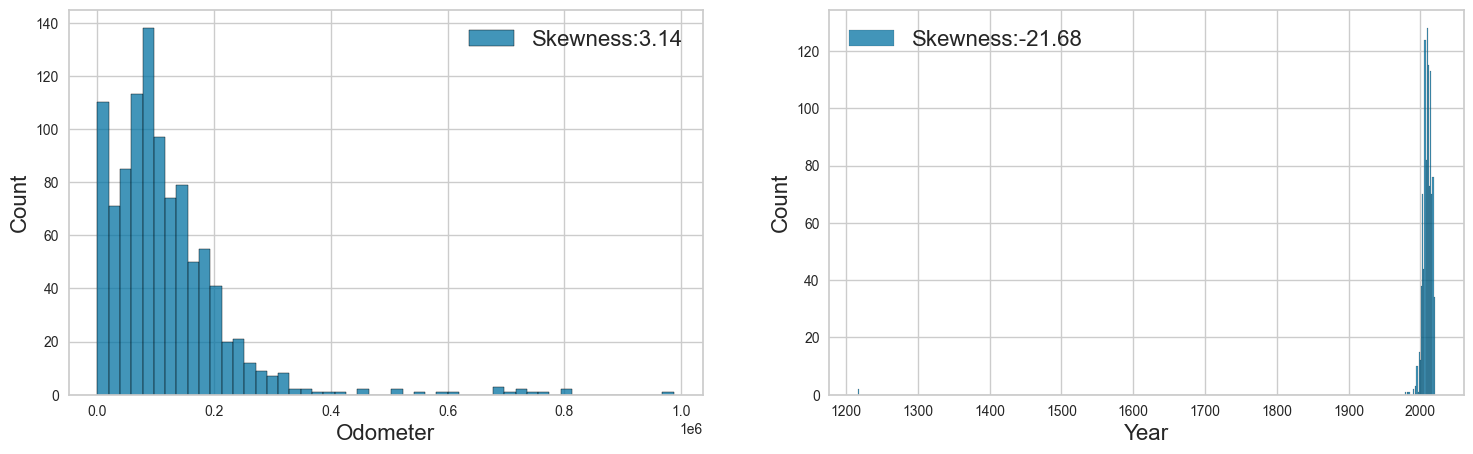

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (18, 5))

g = sns.histplot(df_train['odometer'], color = 'b', label = 
                'Skewness:{:.2f}'.format(df_train['odometer'].skew()), ax = ax[0])
g.legend(loc = 'best', prop = {'size':16})
g.set_xlabel('Odometer', fontsize = 16)
g.set_ylabel('Count', fontsize = 16)

g = sns.histplot(df_train['year'], color = 'b', label = 
                'Skewness:{:.2f}'.format(df_train['year'].skew()), ax = ax[1])
g.legend(loc = 'best', prop = {'size':16})
g.set_xlabel('Year', fontsize = 16)
g.set_ylabel('Count', fontsize = 16)

plt.show()

In [43]:
numeric_fts = ['odometer', 'year']
outlier_ind = []

for i in numeric_fts:
    Q1 = np.percentile(df_train[i], 25)
    Q3 = np.percentile(df_train[i], 75)
    IQR = Q3 - Q1
    outlier_list = df_train[(df_train[i] < Q1 - IQR * 1.5) | (df_train[i] > Q3 + IQR * 1.5)].index
    outlier_ind.extend(outlier_list)

In [44]:
train_df = df_train.drop(outlier_ind, axis = 0).reset_index(drop=True)
train_df

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000
...,...,...,...,...,...,...,...,...,...,...,...
970,1010,Toyota Corolla,46768,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2014,5415000
971,1011,Toyota Camry,31600,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Silver,2011,3615000
972,1012,Toyota Camry,96802,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2011,3415000
973,1013,Lexus GX 460,146275,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Gold,2013,14315000


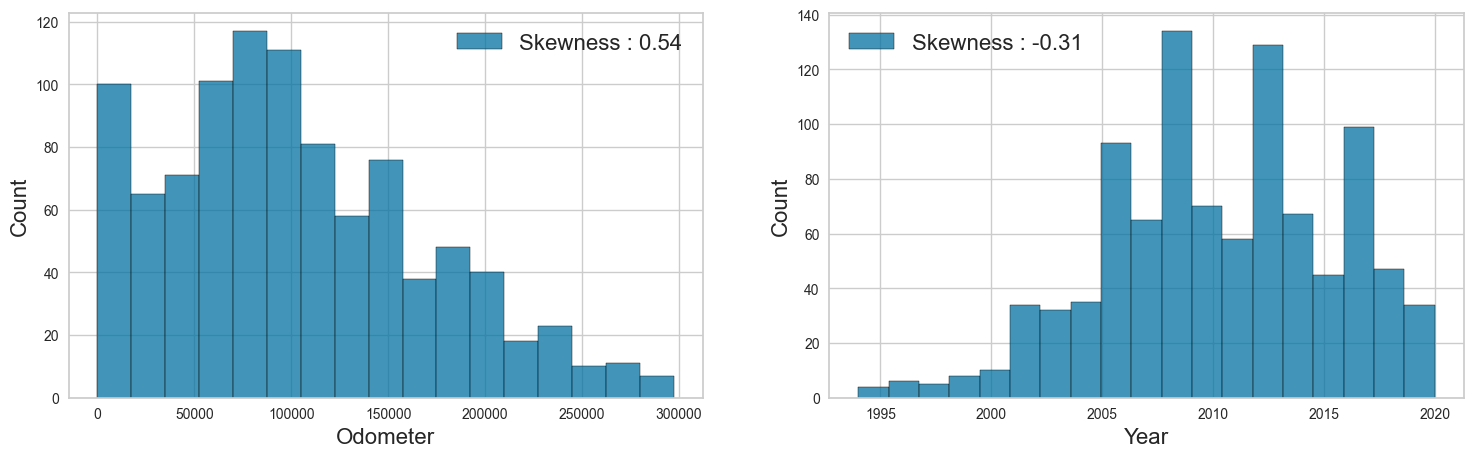

In [18]:
ig, ax = plt.subplots(1, 2, figsize=(18,5))
g = sns.histplot(train_df['odometer'], color='b', label='Skewness : {:.2f}'.format(train_df['odometer'].skew()), ax=ax[0])
g.legend(loc='best', prop={'size': 16})
g.set_xlabel("Odometer", fontsize = 16)
g.set_ylabel("Count", fontsize = 16)

g = sns.histplot(train_df['year'], color='b', label='Skewness : {:.2f}'.format(train_df['year'].skew()), ax=ax[1])
g.legend(loc='best', prop={'size': 16})
g.set_xlabel("Year", fontsize = 16)
g.set_ylabel("Count", fontsize = 16)
plt.show()

#### 👉 outlier 제거하여 첨도 감소함

## Correlation
- 라벨 인코딩

In [19]:
cat_fts = ['title', 'location', 'isimported', 'engine', 'transmission', 'fuel', 'paint']

In [20]:
la_train = train_df.copy()

for i in range(len(cat_fts)):
    encoder = LabelEncoder()
    la_train[cat_fts[i]] = encoder.fit_transform(la_train[cat_fts[i]])

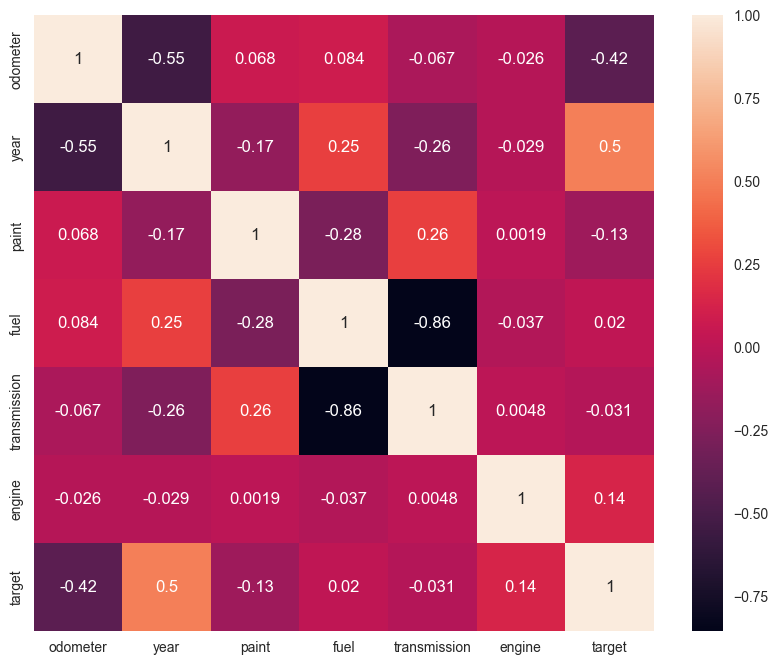

In [21]:
plt.figure(figsize = (10, 8))
sns.heatmap(la_train[['odometer', 'year', 'paint', 'fuel', 'transmission', 'engine', 'target']].corr(), annot=True)
plt.show()

# Feature Engineering

#### company 컬럼 생성
- title 변수들 값 앞부분에 자동차 회사 이름이 오는 것을 확인
- split 함수로, 회사명 데이터 추출, 새 컬럼으로 추가

In [49]:
print(train_df['title'].unique()[:20])

['Toyota RAV 4' 'Toyota Land Cruiser' 'Land Rover Range Rover Evoque'
 'Lexus ES 350' 'Toyota Venza' 'Toyota Corolla'
 'Land Rover Range Rover Sport' 'Pontiac Vibe' 'Toyota Tacoma'
 'Lexus RX 350' 'Ford Escape' 'Honda Civic' 'Volvo XC90' 'BMW 750'
 'Infiniti JX' 'Honda Accord' 'Mercedes-Benz ML 350' 'Toyota Camry'
 'Hyundai Azera' 'Lexus GX 460']


In [50]:
train_df['company'] = train_df['title'].apply(lambda x : x.split(' ')[0])
df_test['company'] = df_test['title'].apply(lambda x : x.split(' ')[0])

print(train_df['company'].unique())
print("#fts:", len(train_df['company'].unique()), "\n")

print(df_test['company'].unique())
print("#fts:", len(df_test['company'].unique()), "\n")

['Toyota' 'Land' 'Lexus' 'Pontiac' 'Ford' 'Honda' 'Volvo' 'BMW' 'Infiniti'
 'Mercedes-Benz' 'Hyundai' 'Jaguar' 'Mitsubishi' 'Nissan' 'Chevrolet'
 'Mazda' 'Lincoln' 'Kia' 'Acura' 'DAF' 'Man' 'Isuzu' 'IVM' 'Porsche'
 'MINI' 'GMC' 'Iveco' 'Scania' 'Volkswagen' 'GAC' 'IVECO' 'Mack' 'Peugeot'
 'Rolls-Royce' 'MAN-VOLKSWAGEN' 'Jeep' 'ALPINA' 'Bentley' 'JMC']
#fts: 39 

['Mercedes-Benz' 'Honda' 'Toyota' 'Iveco' 'Lexus' 'Nissan' 'Volkswagen'
 'Jeep' 'Ford' 'BMW' 'Mack' 'Land' 'Hyundai' 'Peugeot' 'Volvo' 'Infiniti'
 'Acura' 'Man' 'Fiat' 'MINI' 'DAF' 'Mazda' 'Porsche' 'Mitsubishi'
 'Chevrolet' 'Kia' 'Pontiac' 'Rolls-Royce']
#fts: 28 



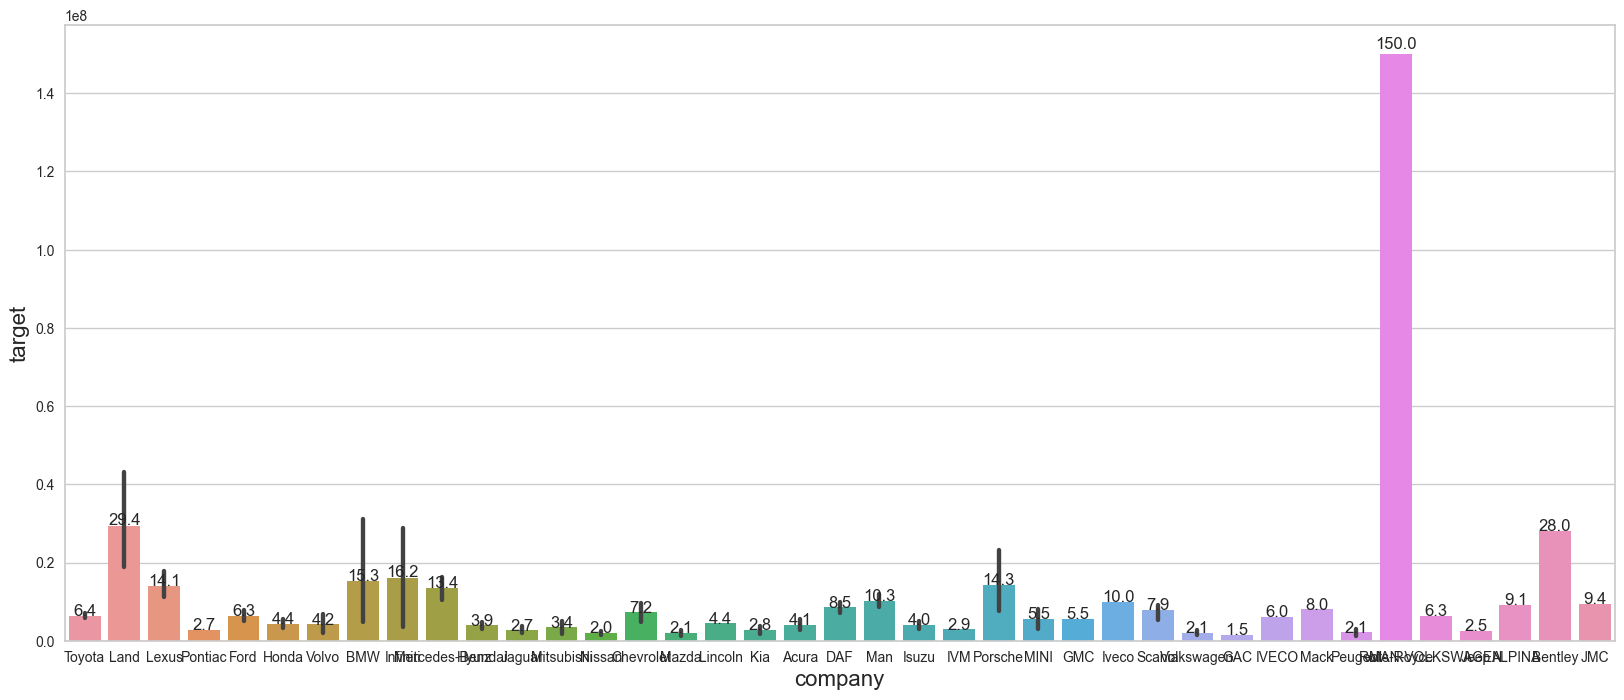

In [51]:
plt.figure(figsize = (20, 8))
g = sns.barplot(x = 'company', y = 'target', data = train_df)

for p in g.patches:
    left, bottom, width, height = p.get_bbox().bounds
    g.annotate("%.1f"%(height/1e6), (left+width/2, height*1.01), ha='center')

g.set_xlabel('company', fontsize = 16)
g.set_ylabel('target', fontsize = 16)
plt.show()

In [52]:
# 막대 높이 저장
company_h = np.zeros(len(g.patches))
i = 0

for p in g.patches:
    left, bottom, width, height = p.get_bbox().bounds
    company_h[i] = (height/1e6)
    i += 1

In [53]:
company_h

array([  6.37849032,  29.39868421,  14.08227273,   2.715     ,
         6.31845588,   4.39417308,   4.15571429,  15.279     ,
        16.16      ,  13.37352941,   3.89282609,   2.665     ,
         3.42      ,   1.98666667,   7.233     ,   2.07875   ,
         4.415     ,   2.81785714,   4.082     ,   8.515     ,
        10.265     ,   4.015     ,   2.89      ,  14.265     ,
         5.54      ,   5.515     ,  10.015     ,   7.93      ,
         2.09409091,   1.49      ,   6.015     ,   8.015     ,
         2.125     , 150.015008  ,   6.34      ,   2.515     ,
         9.065     ,  28.015     ,   9.365     ])

In [54]:
companys = train_df['company'].unique()
companys

array(['Toyota', 'Land', 'Lexus', 'Pontiac', 'Ford', 'Honda', 'Volvo',
       'BMW', 'Infiniti', 'Mercedes-Benz', 'Hyundai', 'Jaguar',
       'Mitsubishi', 'Nissan', 'Chevrolet', 'Mazda', 'Lincoln', 'Kia',
       'Acura', 'DAF', 'Man', 'Isuzu', 'IVM', 'Porsche', 'MINI', 'GMC',
       'Iveco', 'Scania', 'Volkswagen', 'GAC', 'IVECO', 'Mack', 'Peugeot',
       'Rolls-Royce', 'MAN-VOLKSWAGEN', 'Jeep', 'ALPINA', 'Bentley',
       'JMC'], dtype=object)

In [55]:
# df'의 'company' 열을 수정하고, 'train_df'와 'df' 간의 회사 정보 불일치를 처리하는 데 사용

def company_fix(train_df, df, companys):
    only_test_com = list(set(df['company'])-set(train_df['company']))
    
    if len(only_test_com) != 0:
        for k in range(len(only_test_com)):
            print(only_test_com)
            df.loc[(df['company'] == only_test_com[k]), 'company'] = 1


    for c in range(7):
        if c==6:
            company_ind = companys[np.where(company_h>=c*5)]
        elif c==0:
            company_ind = companys[np.where(company_h<(c+1)*5)]
        else:  
            company_ind = companys[np.where((company_h>=c*5)&(company_h<(c+1)*5))]
    
    for i in range(len(company_ind)):
        df.loc[(df['company'] == company_ind[i]), 'company'] = c+1

      